# Airbnb San Francisco - Price prediction

## Packages

In [42]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import geopandas as gpd
import contextily as ctx # Para mapa com background
from shapely.geometry import Point # Construção dos pares de pontos de longitude e latitude

# Ferramentas para o modelo de machine learning

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression # OLS algorithm
from sklearn.metrics import mean_squared_error # Evaluation metric
from sklearn.metrics import r2_score as r2 # Evaluation metric
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer

import xgboost as xgb

import warnings # Estava com uma warning irrelevante nesta célula, por isso estou colocando o filtro até resolver o problema
warnings.filterwarnings("ignore")

## 1 - Preparação e limpeza dos dados

In [2]:
df = pd.read_excel('dados_airbnb_source.xlsx')

In [3]:
df.head(3)

,host_is_superhost,cancellation_policy,instant_bookable,host_total_listings_count,neighbourhood_cleansed,latitude,longitude,property_type,room_type,accommodates,...,bedrooms_na,bathrooms_na,beds_na,review_scores_rating_na,review_scores_accuracy_na,review_scores_cleanliness_na,review_scores_checkin_na,review_scores_communication_na,review_scores_location_na,review_scores_value_na
0,t,moderate,t,1.0,Western Addition,3776931.0,-12243386.0,Apartment,Entire home/apt,3.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,f,strict_14_with_grace_period,f,2.0,Bernal Heights,3774511.0,-12242102.0,Apartment,Entire home/apt,5.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,f,strict_14_with_grace_period,f,10.0,Haight Ashbury,3776669.0,-1224525.0,Apartment,Private room,2.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7146 entries, 0 to 7145
Data columns (total 34 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   host_is_superhost               7146 non-null   object 
 1   cancellation_policy             7146 non-null   object 
 2   instant_bookable                7146 non-null   object 
 3   host_total_listings_count       7146 non-null   float64
 4   neighbourhood_cleansed          7146 non-null   object 
 5   latitude                        7146 non-null   float64
 6   longitude                       7146 non-null   float64
 7   property_type                   7146 non-null   object 
 8   room_type                       7146 non-null   object 
 9   accommodates                    7146 non-null   float64
 10  bathrooms                       7146 non-null   object 
 11  bedrooms                        7146 non-null   float64
 12  beds                            71

In [5]:
df.isna().sum()

host_is_superhost                 0
cancellation_policy               0
instant_bookable                  0
host_total_listings_count         0
neighbourhood_cleansed            0
latitude                          0
longitude                         0
property_type                     0
room_type                         0
accommodates                      0
bathrooms                         0
bedrooms                          0
beds                              0
bed_type                          0
minimum_nights                    0
number_of_reviews                 0
review_scores_rating              0
review_scores_accuracy            0
review_scores_cleanliness         0
review_scores_checkin             0
review_scores_communication       0
review_scores_location            0
review_scores_value               0
price                             0
bedrooms_na                       0
bathrooms_na                      0
beds_na                           0
review_scores_rating_na     

In [6]:
df.duplicated().sum()

0

### Analisando as colunas cujos nomes terminam em "_na"

O .info() do dataframe revelou que tais colunas possuem dados do tipo float. Vamos verificar quais possíveis valores estão nas mesmas.

In [7]:
df.filter(like='_na').apply(lambda value : value.unique(), axis=1).astype('str').unique()

array(['[0.]', '[0. 1.]', '[1. 0.]'], dtype=object)

A célula anterior revela que há apenas '0' e '1' nas colunas em questão, o que poderia ser um indicador booleano da existência de review para o item em questão. No entanto, com os dados que temos, não é possível inferir se essa hipótese corresponde à realidade. Portanto, iremos remover tais colunas do dataframe.

In [8]:
df.drop(columns=df.iloc[:,24:], inplace = True)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7146 entries, 0 to 7145
Data columns (total 24 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   host_is_superhost            7146 non-null   object 
 1   cancellation_policy          7146 non-null   object 
 2   instant_bookable             7146 non-null   object 
 3   host_total_listings_count    7146 non-null   float64
 4   neighbourhood_cleansed       7146 non-null   object 
 5   latitude                     7146 non-null   float64
 6   longitude                    7146 non-null   float64
 7   property_type                7146 non-null   object 
 8   room_type                    7146 non-null   object 
 9   accommodates                 7146 non-null   float64
 10  bathrooms                    7146 non-null   object 
 11  bedrooms                     7146 non-null   float64
 12  beds                         7146 non-null   float64
 13  bed_type          

### Alterando os objetos das colunas binárias para booleanos (t -> 1, f -> 0)

In [9]:
df[['host_is_superhost','instant_bookable']] = df.loc[:,['host_is_superhost','instant_bookable']].apply(lambda x : x.map({'t':1, 'f':0}), axis=1)

In [10]:
df.head(2)

,host_is_superhost,cancellation_policy,instant_bookable,host_total_listings_count,neighbourhood_cleansed,latitude,longitude,property_type,room_type,accommodates,...,minimum_nights,number_of_reviews,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,price
0,1,moderate,1,1.0,Western Addition,3776931.0,-12243386.0,Apartment,Entire home/apt,3.0,...,1.0,180.0,97.0,10.0,10.0,10.0,10.0,10.0,10.0,170.0
1,0,strict_14_with_grace_period,0,2.0,Bernal Heights,3774511.0,-12242102.0,Apartment,Entire home/apt,5.0,...,30.0,111.0,98.0,10.0,10.0,10.0,10.0,10.0,9.0,235.0


### Coluna "bathroom" com dtype object

Tal feature possui object como dtype, no entanto ela deveria representar o número de banheiros presentes na acomodação. Precisamos checar quais tipos de dados há nessa coluna e tratá-los.

In [11]:
df['bathrooms'].unique()

array(['1.0', '4.0', datetime.datetime(2022, 5, 1, 0, 0), '2.0', '3.0',
       '0.0', datetime.datetime(2022, 5, 2, 0, 0),
       datetime.datetime(2022, 5, 3, 0, 0), '0.5', '8.0', '10.0',
       datetime.datetime(2022, 5, 4, 0, 0), '14.0', '5.0',
       datetime.datetime(2022, 5, 5, 0, 0), '6.0'], dtype=object)

Além dos números, que aqui estão como variáveis do tipo str, há alguns valores no formato datetime. Vamos verificar a frequência de ocorrência dos valores.

In [12]:
df['bathrooms'].value_counts()

1.0                    5145
2.0                    1005
2022-05-01 00:00:00     480
2022-05-02 00:00:00     173
3.0                     132
2022-05-03 00:00:00      54
0.0                      39
4.0                      32
5.0                      26
0.5                      17
8.0                      15
10.0                     12
2022-05-04 00:00:00       8
6.0                       6
14.0                      1
2022-05-05 00:00:00       1
Name: bathrooms, dtype: int64

Como não temos informações adequadas para decidir como alterar esses valores no formato .datetime, vamos transformá-los em numpy nan. No entanto, cabe ressaltar que essa parcela dos dados representa cerca de 10% das informações da coluna "bathrooms". Portanto, seria interessante realizar uma pesquisa e uma recoleta desses dados para análises posteriores.

In [13]:
df['bathrooms'] = [np.nan if not isinstance(x, str) else x for x in df['bathrooms']]
df['bathrooms'] = df['bathrooms'].astype(float)

In [14]:
df.accommodates.unique()

array([ 3.,  5.,  2.,  6.,  1.,  4., 10.,  8.,  7., 12., 15., 11.,  9.,
       14., 16., 13.])

In [15]:
df.accommodates = df.accommodates.astype(int)

### Tratando os dados de latitude e longitude

Um detalhe que fica aparente após observamos as primeiras linhas do dataset é que os dados de latitude e longitude não estão formatados adequadamente, pois não estão representados em um dos formatos padrão (para mais detalhes sobre padrões de coordenadas geográficas, veja https://en.wikiversity.or/wiki/Geographic_coordinate_conversion#Basic_forms e https://support.google.com/maps/answer/18539?hl=en). 

Para permitir uma manipulação mais eficiente desses dados e sua posterior utilização, vamos assumir que os valores estão no formato conhecido como Decimal Degrees (DD), no entanto sem a devida marcação das casas decimais por algum erro na obtenção dos dados. 

Lembrando que a latitude varia de 0 a 90º (Norte ou Sul), enquanto que a longitude varia de 0 a 180º (Leste ou Oeste). Convenciona-se que um sinal de (-) na latitude indica que o lugar está localizado abaixo da linha do equador, ou seja, no hemisfério sul, enquanto que um sinal de (-) na longitude indica que o lugar está no hemisfério oeste. Exemplo com as coordenadas geográficas de Belo Horizonte: latitude -19.912998 e longitude -43.940933.

Portanto, tomando como exemplo o par latitude e longitude da primeira linha do dataframe, 3776931.0 e -12243386.0, estamos assumindo que os valores corretos seriam 37.76931 e -122.43386, o que condiz com o bairro presente no dataframe, localizado na cidade de São Francisco, Califórnia.

Para tratar os dados, vamos utilizar as seguintes funções.

In [16]:
def transformLatitude(lat):
    lat = str(lat)
    lat = lat[0:2] + '.' + lat[2:-2]
    lat = float(lat)
    return lat

def transformLongitude(lon):
    lon = str(lon)
    lon = lon[0:4] + '.' + lon[4:-2]
    lon = float(lon)
    return lon

In [17]:
df['latitude'] = df['latitude'].apply(lambda x : transformLatitude(x) if x > 100 else x)
df['longitude'] = df['longitude'].apply(lambda x : transformLongitude(x) if x < -130 else x)

In [18]:
df.to_excel('airbnb_data_cleansed.xlsx')

## 2 - Análise Exploratória

Concluída uma primeira etapa de processamento e limpeza dos dados, vamos formular e responder com uma análise exploratória algumas perguntas referentes a uma maior rentabilidade e/ou taxa de ocupação das acomodações.
1. Quais são os bairros com maior oferta? Quais tipos de acomodação são anunciados mais frequentemente?
2. Quais são os bairros mais caros? Como essa informação se compara com os bairros mais vistos nos anúncios? 
3. O número de quartos e/ou banheiros na acomodação influencia diretamente no preço?
4. Qual é a relação entre o número de pessoas suportado pela acomodação e o preço?
5. Os preços são afetados pela política de cancelamento da acomodação?

Vamos começar exibindo informações sobre as acomodações por região e por tipo.

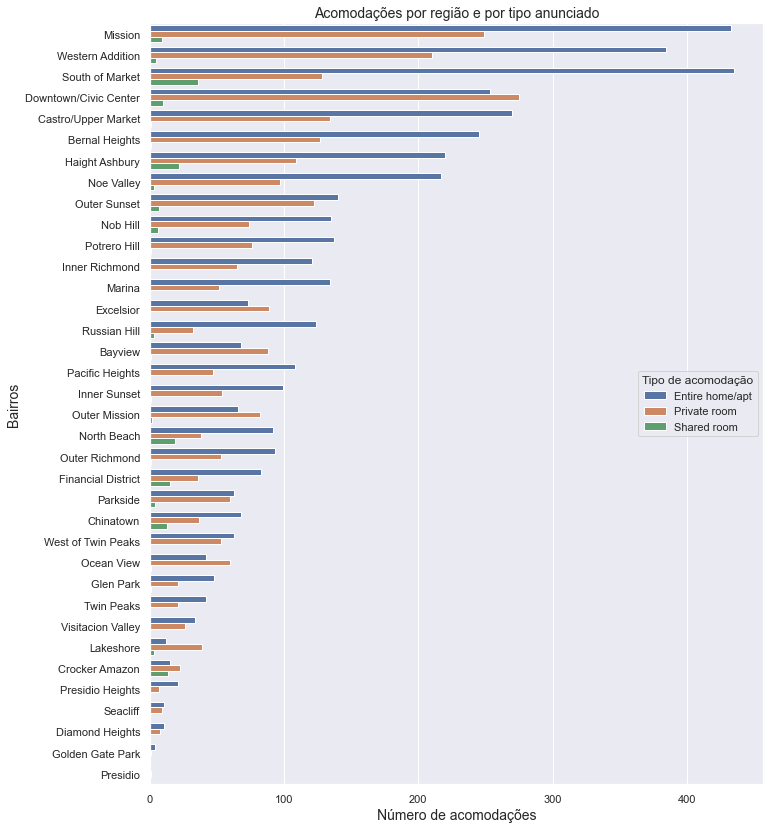

In [19]:
sns.set()
fig, ax = plt.subplots(figsize=(11, 14))
sns.countplot(data=df, y='neighbourhood_cleansed', hue='room_type', order = df.neighbourhood_cleansed.value_counts().index, ax=ax)
ax.set_xlabel('Número de acomodações', fontsize=14)
ax.set_ylabel('Bairros', fontsize=14)
ax.set_title('Acomodações por região e por tipo anunciado', fontsize=14)
ax.legend(title='Tipo de acomodação')
plt.show()

Este primeiro gráfico nos permite visualizar em ordem decrescente os bairros com maior número de anúncios no dataset, além de discriminar os anúncios por tipo de acomodação, que se dividem em três categorias: <code>Entire home/apt</code>, <code>Private room</code> e <code>Shared room</code>, isto é, Casa/apt inteiro, quarto privativo e quarto compartilhado. Fica evidente por este gráfico que a categoria <code>Entire home/apt</code> é a mais vista nos anúncios, seguida por <code>Private room</code>. Ademais, o número de anúncios na categoria <code>Shared room</code> é muito menor do que os números das demais categorias.

Vamos analisar agora como é a distribuição dos preços presentes no dataset.

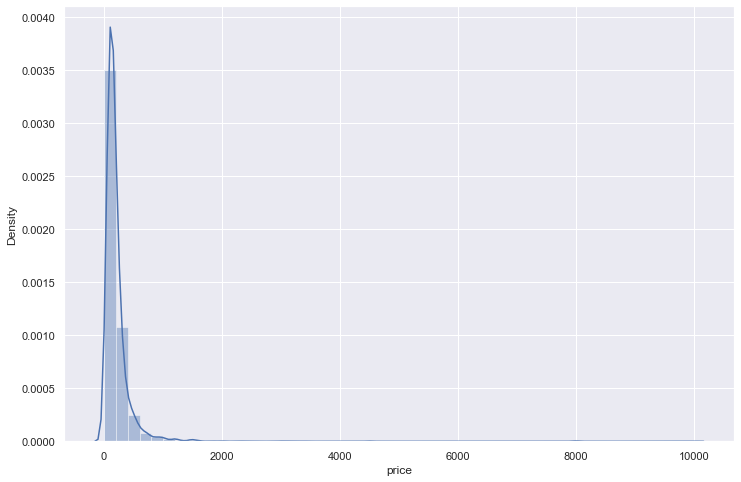

In [20]:
fig, ax = plt.subplots(figsize=(12,8))
sns.distplot(df.price, ax=ax)
plt.show()

É notável que a distribuição dos preços é antissimétrica e afunilada. Esses são indicativos de que ela não se assimila a uma distribuição normal. Por essa razão, para fazer uma análise dos preços por tipo de acomodação, é mais relevante agrupar tais dados utilizando a mediana dos preços, tornando nossa medida de tendência central menos suscetível aos efeitos dos outliers de preços.

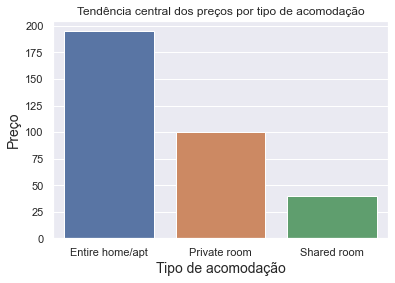

In [21]:
rtype_price = df.groupby('room_type')['price'].median()
sns.barplot(data=df, x=rtype_price.index, y=rtype_price)
plt.xlabel('Tipo de acomodação', fontsize=14)
plt.ylabel('Preço', fontsize=14)
plt.title('Tendência central dos preços por tipo de acomodação')
plt.show()

Podemos agora exibir um mapa da cidade de São Francisco contendo os pontos dos anúncios, de acordo com os respectivos valores de longitude e latitude. Para aprimorar o plot, iremos ainda tingir os pontos de acordo com seu preço, para que seja possível identificar regiões mais caras e mais baratas.

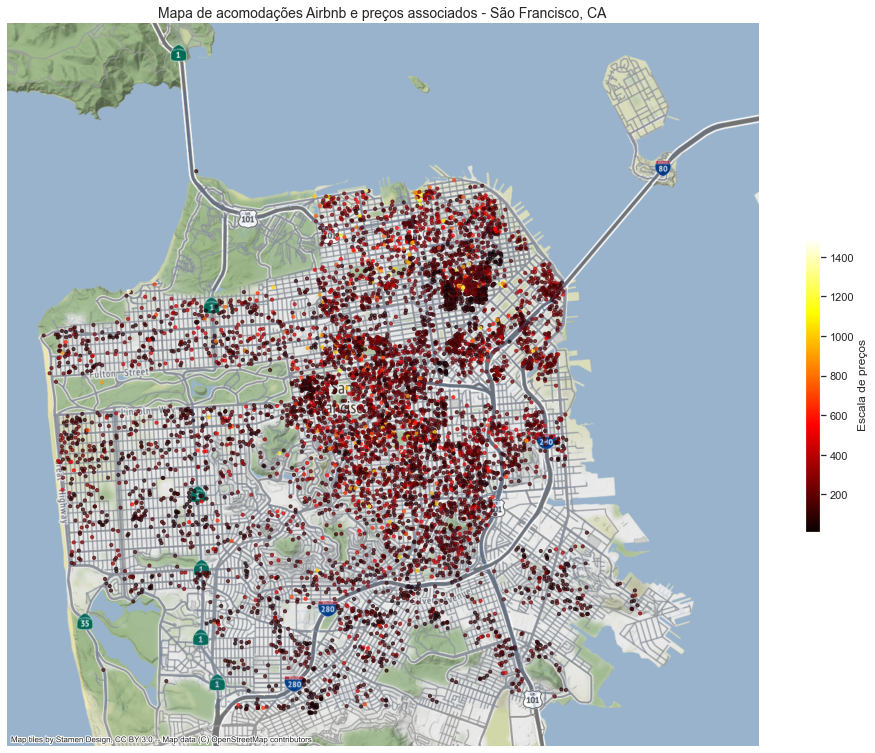

In [22]:
# Leitura do arquivo com o mapa, utilizando o geopandas
sf_df = gpd.read_file('tl_2017_06075_roads/tl_2017_06075_roads.shp')

# Alterando o crs do geodataframe para que possamos utilizar o módulo contextily e inserir o mapa colorido
sf_df = sf_df.to_crs(epsg=3857)

# Criando uma coluna com as coordenadas geográficas dos anúncios e um novo geodataframe que contenha df e tal coluna
points = [Point(p) for p in zip(df.longitude,df.latitude)]
houses_geo_df = gpd.GeoDataFrame(df,geometry=points)

# Filtrando o geodataframe para que os outliers de preço não interfiram na escala de cores
houses_gdf_filtered = houses_geo_df[houses_geo_df['price'] < 1500]

# Inicializar o crs para 4326 pois é o formato da nossa geometria
houses_gdf_filtered.crs = "EPSG:4326"

# Alterando o crs para coincidir com o crs do geodataframe sf_df
houses_gdf_filtered = houses_gdf_filtered.to_crs(epsg = 3857)

# Plotando
fig, ax = plt.subplots(figsize=(14,14))

sf_df.plot(ax=ax, alpha = .1)

houses_gdf_filtered.plot(ax=ax, marker = 'o', column='price', cmap='hot' ,markersize=10, legend=True, legend_kwds={'shrink': 0.3, 'label': "Escala de preços"}, alpha=0.7)

# Adicionando o background à imagem utilizando o contextily
ctx.add_basemap(ax)

fig.tight_layout()
ax.set_axis_off()
plt.title("Mapa de acomodações Airbnb e preços associados - São Francisco, CA", fontsize=14)
plt.savefig('accomodations_geospacial_2.png')

In [23]:
df.drop(columns='geometry', inplace=True)

A primeira coisa a se destacar nessa visualização é que realizamos um filtro no dataframe, para que ele contenha somente acomodações cujos preços são menores ou iguais a $1500.00. Isso foi feito para que a distribuição dos preços não fosse afetada pelos outliers, conforme apontado anteriormente. Deste modo, a sensibilidade dos pontos ao mapa de cores fica maior, permitindo uma interpretação mais clara dos respectivos preços dos anúncios.

Sobre a distribuição dos pontos por região, fica claro que grande parte dos anúncios se concentra na região central da cidade, possivelmente por conta de um maior número de atrações turísticas. Inclusive, é na região central e nos seus arredores que conseguimos identificar uma quantidade maior de pontos de cor vibrante, indicando um maior preço. Por outro lado, a maioria dos pontos detém cores mais escuras, indicando uma predominância de anúncios cujo valor é inferior a $400.00

Vamos agora identificar os bairros com anúncios mais caros. Uma hipótese que podemos fazer, nos apoiando no mapa de preços anterior, é que os bairros mais caros, em geral, não são os bairros com maior número de anúncios na plataforma. Isso porque as acomodações mais caras possivelmente são residências de luxo, que se localizam em condomínios ou áreas mais afatadas, diferentemente das acomodações mais acessíveis, que ficam na região central e perto das principais atraçõe da cidade.

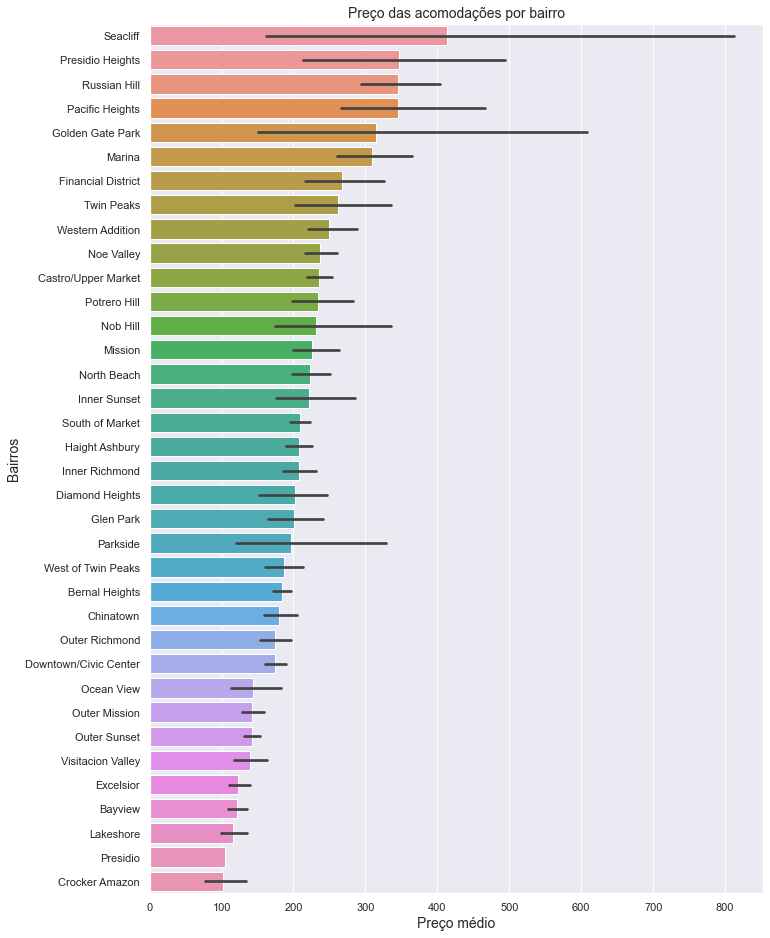

In [24]:
group = df.groupby('neighbourhood_cleansed')['price'].mean().sort_values(ascending=False)
fig, ax = plt.subplots(figsize=(11, 16))
sns.barplot(data=df, x='price', y='neighbourhood_cleansed', order=group.index, ax=ax)
ax.set_xlabel('Preço médio', fontsize=14)
ax.set_ylabel('Bairros', fontsize=14)
ax.set_title('Preço das acomodações por bairro', fontsize=14)
plt.show()

Começamos observando que para essa visualização agrupamos os bairros com os preços *médios* e sem filtrar os valores de preço, pois estávamos interessados em visualizar os bairros mais caros considerando todos os valores da feature <code>price</code>. Deste modo, é possível comparar os bairros com maior número de oferta e os bairros com anúncios mais caros e baratos. Observamos que os intervalos de confiança da média em alguns bairros é extremamente grande, superando até mesmo o tamanho da barra no caso dos bairros <code>Seacliff</code> e <code>Golden Gate Park</code>. Tais bairros, portanto, possuem anúncios com preços altíssimos em comparação com os demais anúncios dessa categoria, puxando a barra de erro para a direita.

Um outro insight que podemos extrair desse plot é que a hipótese formulada anteriormente se confirma: o top 5 de bairros mais caros, <code>Seacliff</code>,  <code>Presidio Heights</code>, <code>Russian Hill</code>, <code>Pacific Heights</code> e <code>Golden Gate Park</code>, não inclui nenhum dos bairros no top 5 daqueles com maior número de anúncios, <code>Mission</code>, <code>Western Addition</code>, <code>South of Market</code>, <code>Downtown/Civic Center</code> e <code>Castro/Upper Market</code>.

Curiosamente, <code>Golden Gate Park</code>, <code>Seacliff</code> e <code>Presidio Heights</code>, são, respectivamente, o 2º, 4º e 5º últimos bairros no gráfico de número de anúncios.



Tratemos agora de analisar características internas das acomodações, como número de banheiros, quartos e capacidade de pessoas e verificar como isso se relaciona com os preços. Para tanto, para que os dados não sofram com os outliers, filtraremos as linhas do dataset cujos preços são iguais ou inferiores a $500.00.

In [25]:
df_price_filtered = df[df.price <= 500]

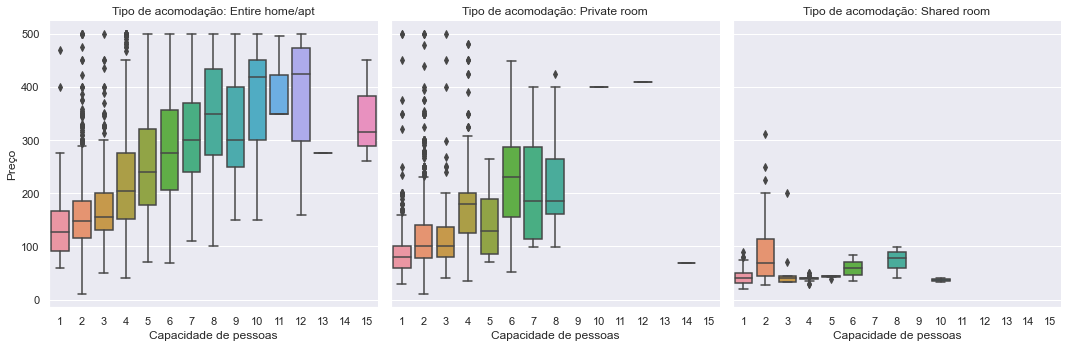

In [26]:
g = sns.catplot(data=df_price_filtered, x='accommodates', y='price', kind='box', col='room_type')
g.set_axis_labels('Capacidade de pessoas', 'Preço')
g.set_titles('Tipo de acomodação: {col_name}')
plt.show()

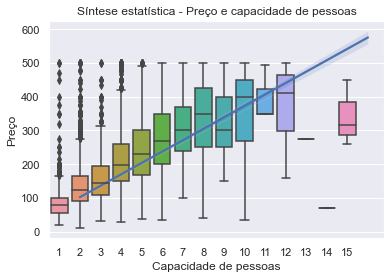

In [27]:
sns.boxplot(data=df_price_filtered, x='accommodates', y='price')
sns.regplot(data=df_price_filtered, x='accommodates', y='price', scatter=False)
plt.xlabel('Capacidade de pessoas')
plt.ylabel('Preço')
plt.title('Síntese estatística - Preço e capacidade de pessoas')
plt.show()

É notável que a mediana do preço cresce em uma tendência linear para acomodações cuja capacidade de pessoas é entre 2 e 10. Para acomodações que comportam mais pessoas, essa tendência já não fica tão clara. 

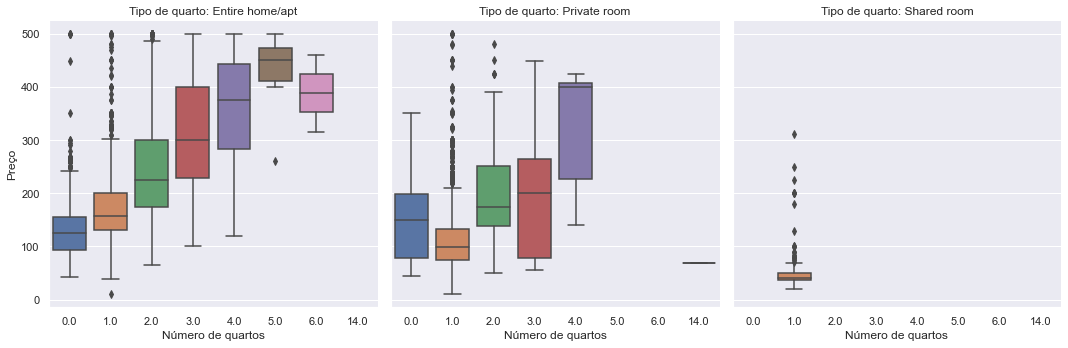

In [28]:
g = sns.catplot(data=df_price_filtered, x='bedrooms', y='price', kind='box', col='room_type')
g.set_axis_labels('Número de quartos', 'Preço')
g.set_titles('Tipo de quarto: {col_name}')
plt.show()

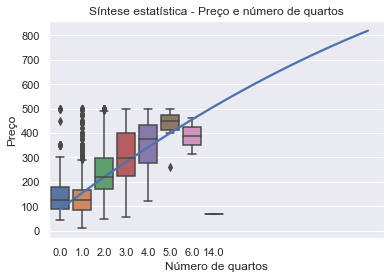

In [29]:
sns.boxplot(data=df_price_filtered, x='bedrooms', y='price')
sns.regplot(data=df_price_filtered, x='bedrooms', y='price', order=2, scatter=False, ci=None)
plt.xlabel('Número de quartos')
plt.ylabel('Preço')
plt.title('Síntese estatística - Preço e número de quartos')
plt.show()

No caso da relação entre o número de quartos e o preço, vemos uma tendência de crescimento quadrática para a mediana, partindo de 0 quartos disponíveis até 6 quartos. Acima desse valor não podemos inferir essa tendência.

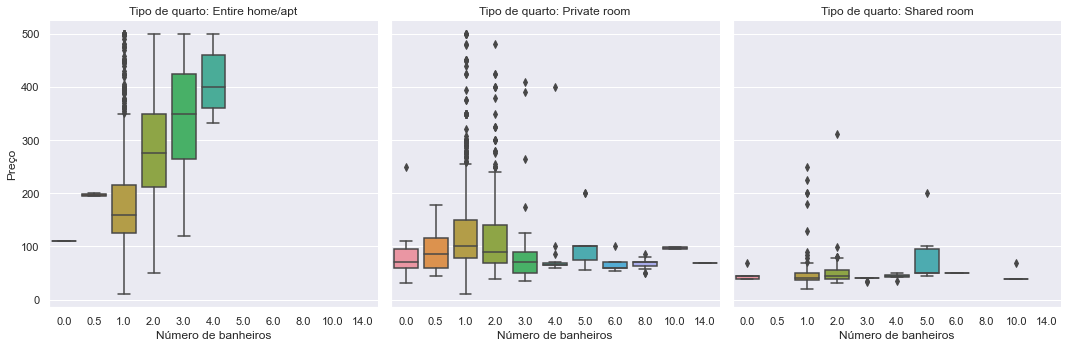

In [30]:
g = sns.catplot(data=df_price_filtered, x='bathrooms', y='price', kind='box', col='room_type')
g.set_axis_labels('Número de banheiros', 'Preço')
g.set_titles('Tipo de quarto: {col_name}')
plt.show()

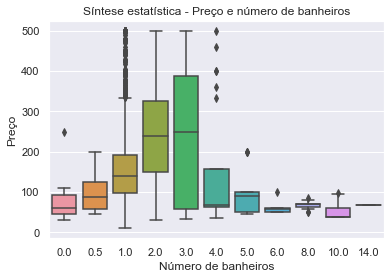

In [31]:
sns.boxplot(data=df_price_filtered, x='bathrooms', y='price')
plt.xlabel('Número de banheiros')
plt.ylabel('Preço')
plt.title('Síntese estatística - Preço e número de banheiros')
plt.show()

A relação entre o númeo de banheiros disponíveis e preço não parece ser relevante, apesar de vermos uma possível tendência de crescimento quadrática para a mediana, partindo de 0 até 3 banheiros.

Consideremos agora a relação entre preços e política de cancelamento.

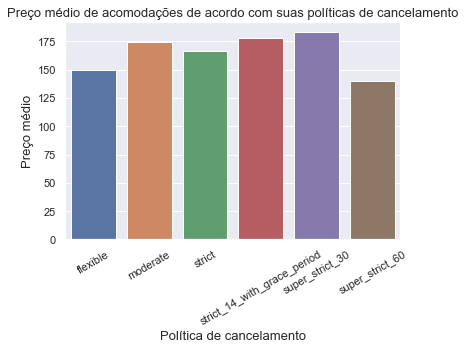

In [32]:
cancel_price = df_price_filtered.groupby('cancellation_policy')['price'].mean()
sns.barplot(data=df_price_filtered, x=cancel_price.index, y=cancel_price)
plt.xlabel('Política de cancelamento', fontsize=13)
plt.ylabel('Preço médio', fontsize=13)
plt.title('Preço médio de acomodações de acordo com suas políticas de cancelamento', fontsize=13)
plt.xticks(rotation=30)
plt.show()

In [33]:
df_price_filtered.cancellation_policy.value_counts()

strict_14_with_grace_period    2851
moderate                       2433
flexible                       1376
super_strict_30                  66
strict                           43
super_strict_60                   4
Name: cancellation_policy, dtype: int64

Finalmente, vamos construir um mapa de calor para exibir a correlação entre as variáveis no dataset.

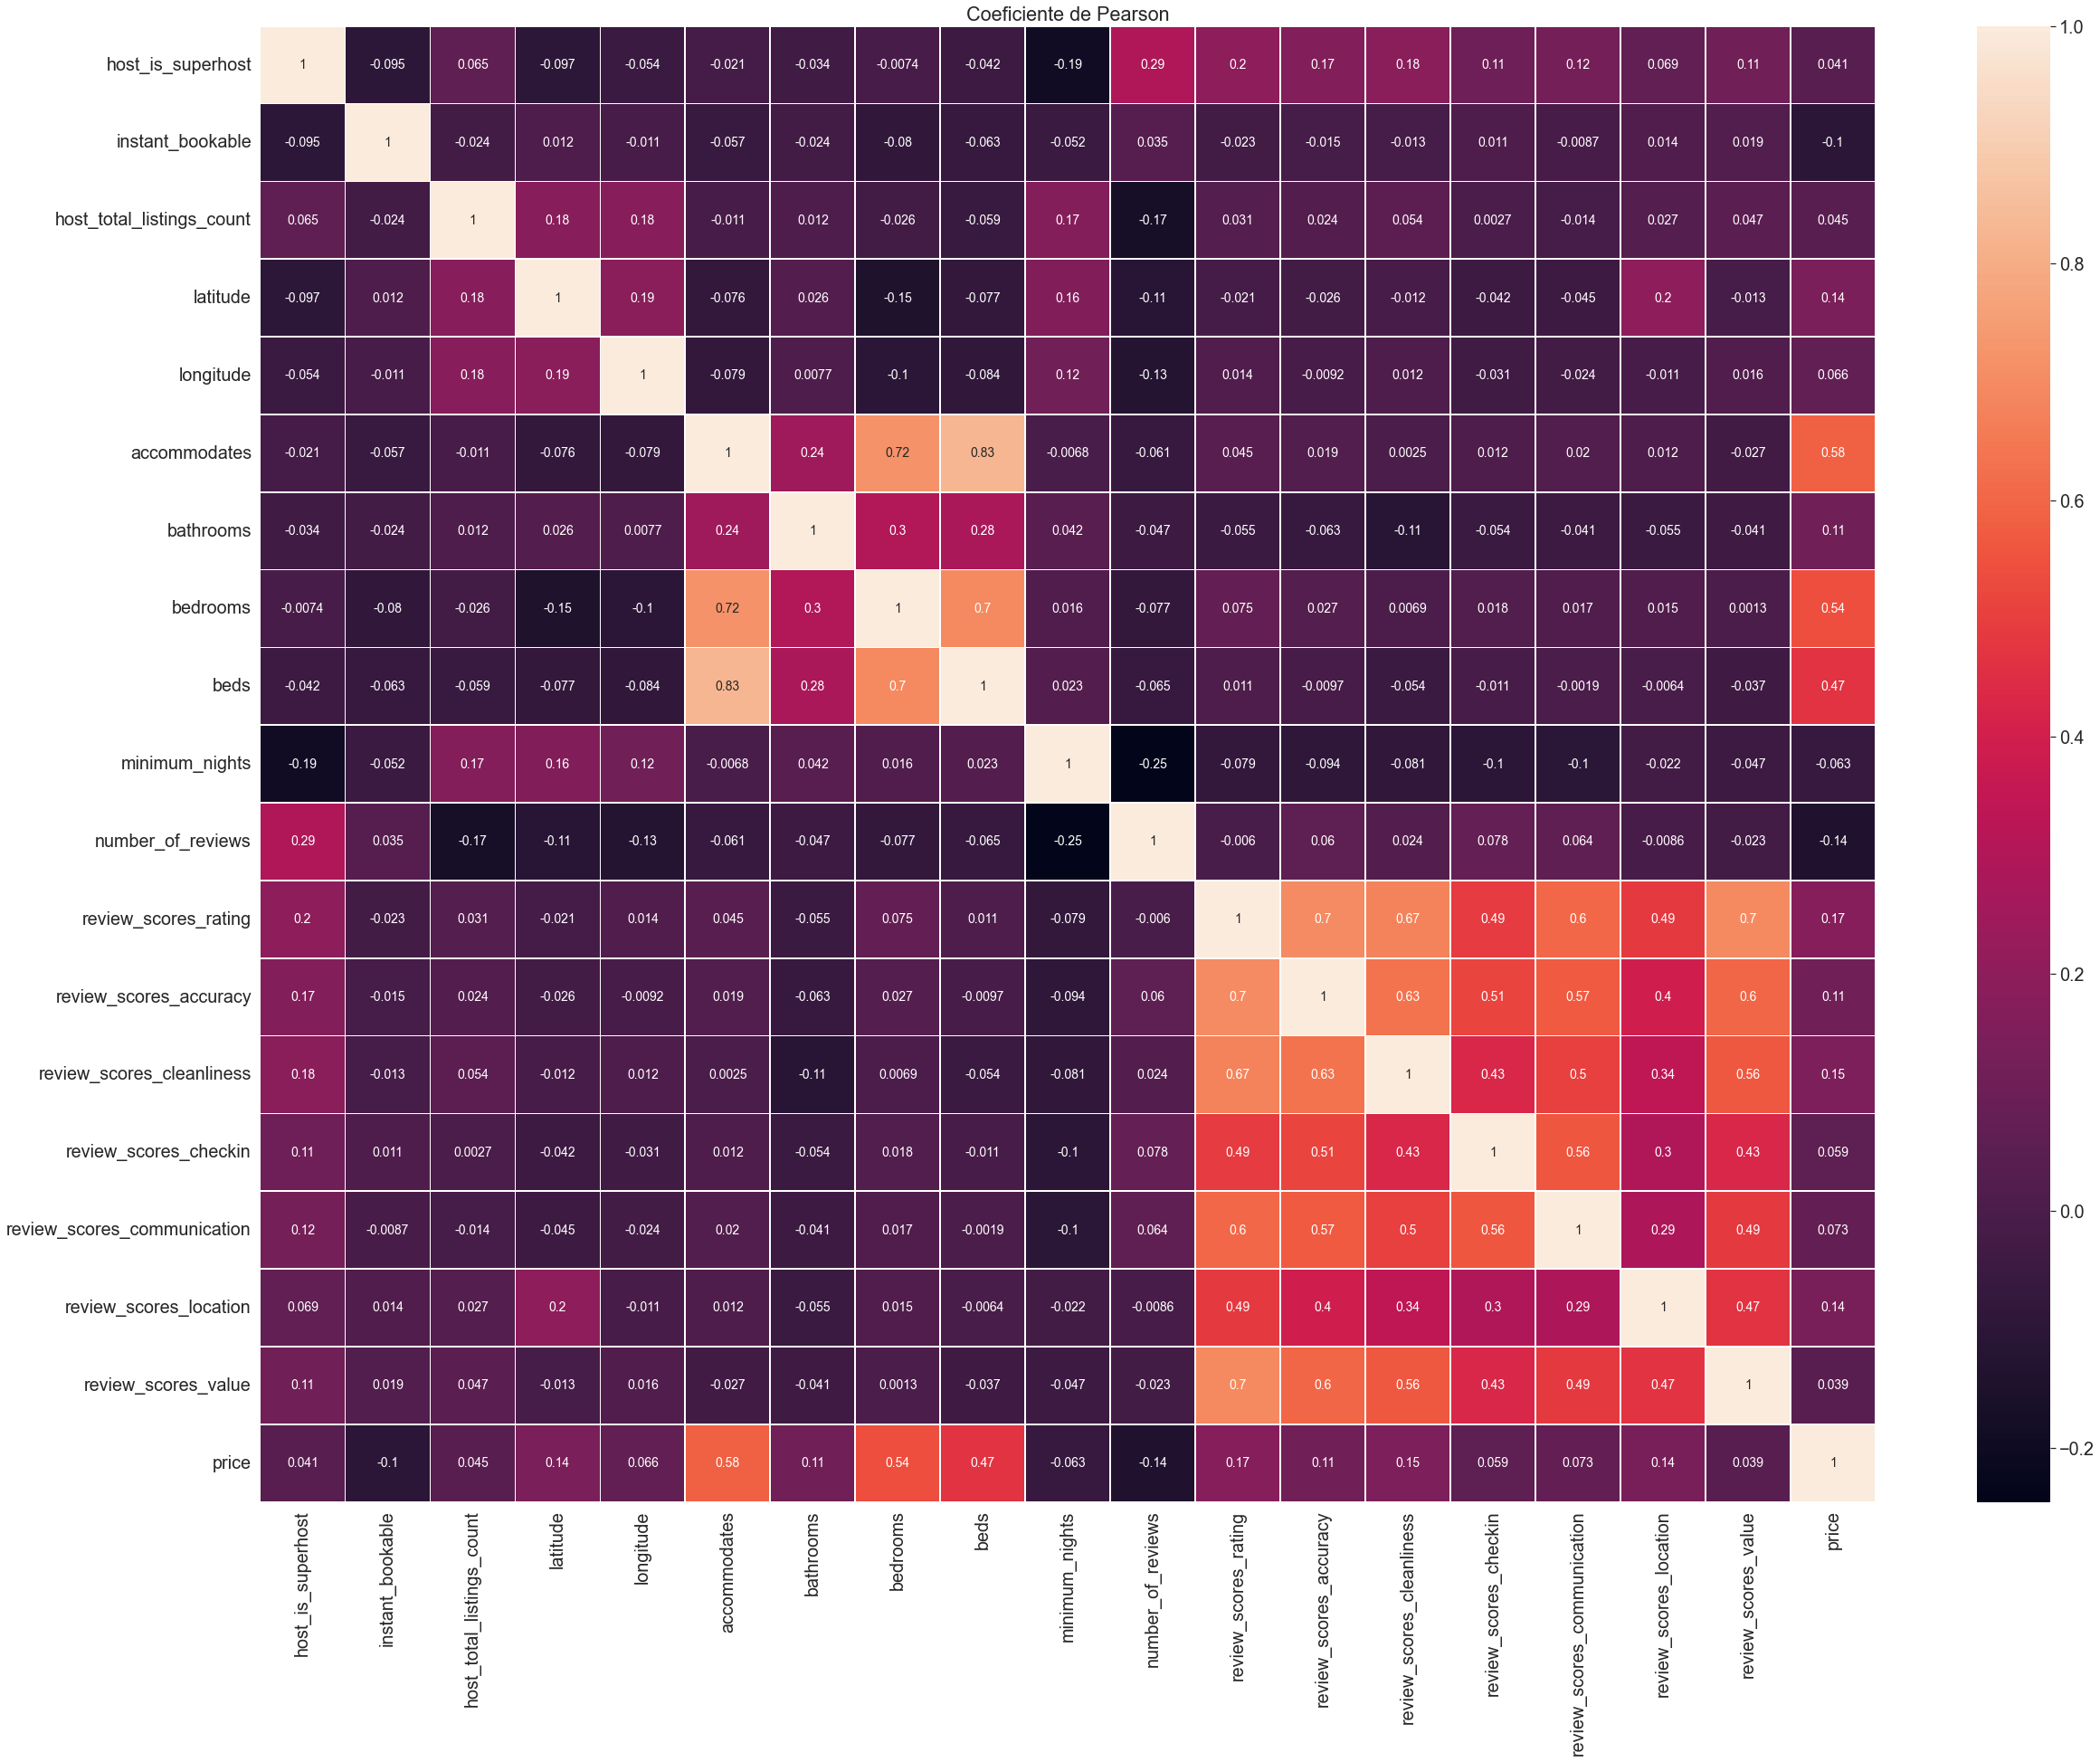

In [34]:
# Aplicando coeficiente de correlação de Pearson para o dataframe com preços filtrados
df_corr = df_price_filtered.corr()

# Visualizar a correlação entre cada variável utilizando a correlação de Pearson
sns.set(font_scale=1.8)
fig, ax = plt.subplots(figsize = (40,30))
sns.heatmap(df_corr, vmax = 1, linewidths = 0.7,annot_kws={"size": 14},annot=True)
ax.set_title('Coeficiente de Pearson')
plt.show()

O mapa de calor revela que não há relações lineares significativas entre <code>price</code> e as demais features do dataset.

## 3 - Modelos

Nós iremos construir modelos de regressão utilizando <code>sklearn</code> e XGBoost para comparar os resultados das métricas. 

Ademais, como já foi detectado que anúncios cujos valores são superiores a $500.00 interferem negativamente na análise estatística dos dados, iremos fazer o modelo considerando a maior amostra de anúncios, cujos valores são menores ou iguais a este valor.

### Regressão Linear

Vamos começar com o modelo de regressão linear do sklearn, que utiliza o método OLS (ordinary least squares). Nesse caso, precisamos remover os valores <code>nan</code> do dataset e transformar as variáveis categóricas em numéricas. Para tanto, faremos um pipeline que 1) substituirá os <code>nan</code> com um SimpleImpute, 2) fará o encoding das variáveis categóricas com OneHotEncoder() e 3) Irá regularizar as variáveis numéricas com um o StandardScaler().

In [35]:
df_reg = df_price_filtered.copy()

In [36]:
# Separação das features 
X = df_reg.drop(columns='price')
y = df_reg['price']

# Criando listas com as features categóricas e numéricas para o enconding e o scaling
obj_features = df_reg.dtypes[df_reg.dtypes == object].index
num_features = df_reg.drop(columns='price').dtypes[df_reg.dtypes != object].index
cat_features = obj_features.astype('category')
cat_features = list(cat_features)
num_features = list(num_features)
display(cat_features, num_features)

['cancellation_policy',
 'neighbourhood_cleansed',
 'property_type',
 'room_type',
 'bed_type']

['host_is_superhost',
 'instant_bookable',
 'host_total_listings_count',
 'latitude',
 'longitude',
 'accommodates',
 'bathrooms',
 'bedrooms',
 'beds',
 'minimum_nights',
 'number_of_reviews',
 'review_scores_rating',
 'review_scores_accuracy',
 'review_scores_cleanliness',
 'review_scores_checkin',
 'review_scores_communication',
 'review_scores_location',
 'review_scores_value']

In [37]:
# ColumnTransformer e pipeline principal
num_transformer = Pipeline(steps=[('imputer', SimpleImputer(strategy='median')), ('scaler', StandardScaler())])
cat_transformer = OneHotEncoder(handle_unknown='ignore')

preprocessor = ColumnTransformer(
    transformers=[
        ('num', num_transformer, num_features),
        ('cat', cat_transformer, cat_features)
    ],
    remainder='passthrough'
)

pipe = Pipeline(steps=[('preprocessor', preprocessor),
                       ('model', LinearRegression())])

In [38]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=7)

pipe.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['host_is_superhost',
                                                   'instant_bookable',
                                                   'host_total_listings_count',
                                                   'latitude', 'longitude',
                                                   'accommodates', 'bathrooms',
                                                   'bedrooms', 'beds',
                                                   'minimum_nights',
                                                   'number_of_...s',
                                                   'review_scores_rating',
                                                   'review_scores_accuracy',
                                                   'review_scores_cleanliness',
                                                   'review_scores_checkin',
                                                   'review_scores_communication',
                                                   'review_scores_location',
                                                   'review_scores_value']),
                                                 ('cat',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['cancellation_policy',
                                                   'neighbourhood_cleansed',
                                                   'property_type', 'room_type',
                                                   'bed_type'])])),
                ('model', LinearRegression())])

In [39]:
y_pred = pipe.predict(X_test)
print(('R^2 do modelo OLS é {}'.format(r2(y_test, y_pred))))
print(('RMSE do modelo OLS é {}'.format(mean_squared_error(y_test, y_pred, squared=False))))

R^2 do modelo OLS é 0.566029909174429
RMSE do modelo OLS é 67.45713228141298


### XGBoost Regression

Vamos agora considerar o modelo XGBoost. Este modelo tem se tornado mais popular e importante, especialmente em competições do Kaggle. Mais detalhes sobre o mesmo podem ser encontrados em https://xgboost.readthedocs.io/en/stable/ .

In [40]:
# Separação das features, lembrando que aqui o dataset ainda contém os nan na feat 'bathrooms'
df_xgb = df_price_filtered.copy()
X_xgb = df_xgb.drop(columns='price')
y_xgb = df_xgb['price']

# Split antes do encoding para evitar data leakage
X_train, X_test, y_train, y_test = train_test_split(X_xgb, y_xgb, test_size=0.2, random_state=1)

# Pipeline com encoding e modelo de regressão
preprocess_xgb = ColumnTransformer(
    transformers=[
        ('cat_xgb', cat_transformer, cat_features)
    ],
    remainder='passthrough'
)
pipe_xgb = Pipeline(steps=[('preprocess_xgb', preprocess_xgb),('xgb_model', xgb.XGBRegressor())])

In [41]:
pipe_xgb.fit(X_train,y_train)

xgb_pred = pipe_xgb.predict(X_test)

print(('R^2 do modelo XGBoost é {}'.format(r2(y_test, xgb_pred))))

print(('RMSE do modelo XGBoost é {}'.format(mean_squared_error(y_test, xgb_pred, squared=False))))

R^2 do modelo XGBoost é 0.6478924011172793
RMSE do modelo XGBoost é 60.94415794873048


## 4 - Observações e possíveis melhorias

É possível ver através das métricas que o modelo utilizando XGBoost performou melhor nos dados de teste do que os modelos de regressão linear OLS. Com efeito, o RMSE do modelo XGBoost é menor do que o respectivo erro do modelo OLS, enquanto que o R2-score do modelo XGBoost está dentro do aceitável, acima de 60%.

Cabe ressaltar que um trabalho mais minucioso de feature selection e de investigação da influência dos hiperparâmetros se faz necessário para melhorar a performance de ambos os modelos. Por fim, uma análise interessante pode ser avaliar como os modelos de regressão Lasso e Ridge atuam nesses dados, realizando cross validation e tunning de hiperparâmetros.

## 5 - Conclusões

Iniciamos a solução do problema importando os dados e fazendo uma avaliação do conteúdo do dataset. Posteriormente, 
os dados foram tratados para uma melhor análise e para possibiltar a construção dos modelos de machine learning. Em seguida, fizemos uma análise exploratória para nos ajudar com feature selections e obtivemos alguns insights sobre a relação dos preços dos anúncios com alguns features. Finalmente, construímos 2 modelos diferentes, um utilizando o algoritmo LinearRegression() da biblioteca sklearn e outro utilizando XGBoost.

Este último modelo foi o que melhor performou. No entanto, como apontado na seção anterior, cabe aprimorá-lo, como, por exemplo, utilizando melhores features e ajustando hiperparâmetros.

### Produtização do modelo

Assumindo que o modelo foi aprimorado e os resultados nos conjuntos de teste estão satisfatórios, poderíamos passar para uma fase de deploy. Nesse caso, seria interessante criar uma pipeline para ingestão de novos dados e conectá-la a um banco de dados. Os dados então seriam ingeridos e passariam pela etapa de processamento e limpeza em um arquivo .py independente. A etapa de análise exploratória poderia ser realizada em um arquivo .py apartado, construído sob o paradigma de programação orientada a objeto e/ou com funções mais gerais para plotar e exibir os gráficos. Finalmente, como um arquivo .py independente, o modelo de machine learning receberia os dados já tratados e com as features mais relevantes, podendo então realizar as predições. O deploy poderia ser feito com o auxílio de uma biblioteca open-source para Python chamada BentoML, veja mais detalhes em https://www.bentoml.com/.

### Utilização do produto

Uma possível utilização do produto seria integrá-lo ao app da empresa como uma feature para os hosts. Com ela, os anunciantes poderiam inserir um conjunto de informações sensíveis para o modelo predizer um valor adequado para a acomodação, de modo a maximizar o lucro do host e manter o preço competitivo, conforme as características da acomodação e as ofertas concorrentes.